In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import vgg19, VGG19_Weights

In [2]:
style_img = Image.open("./notebook_images/starry_night.jpg")

In [3]:
img_size = 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [4]:
style_tensor = transform(style_img)
style_tensor = style_tensor.unsqueeze(0)
print(f"style_tensor shape: {style_tensor.shape}")

style_tensor shape: torch.Size([1, 3, 128, 128])


In [5]:
noise_tensor = torch.randn((1, 3, 128, 128))
print(f"noise_tensor shape: {noise_tensor.shape}")

noise_tensor shape: torch.Size([1, 3, 128, 128])


In [6]:
untransform = transforms.Compose([
    transforms.ToPILImage(),
])

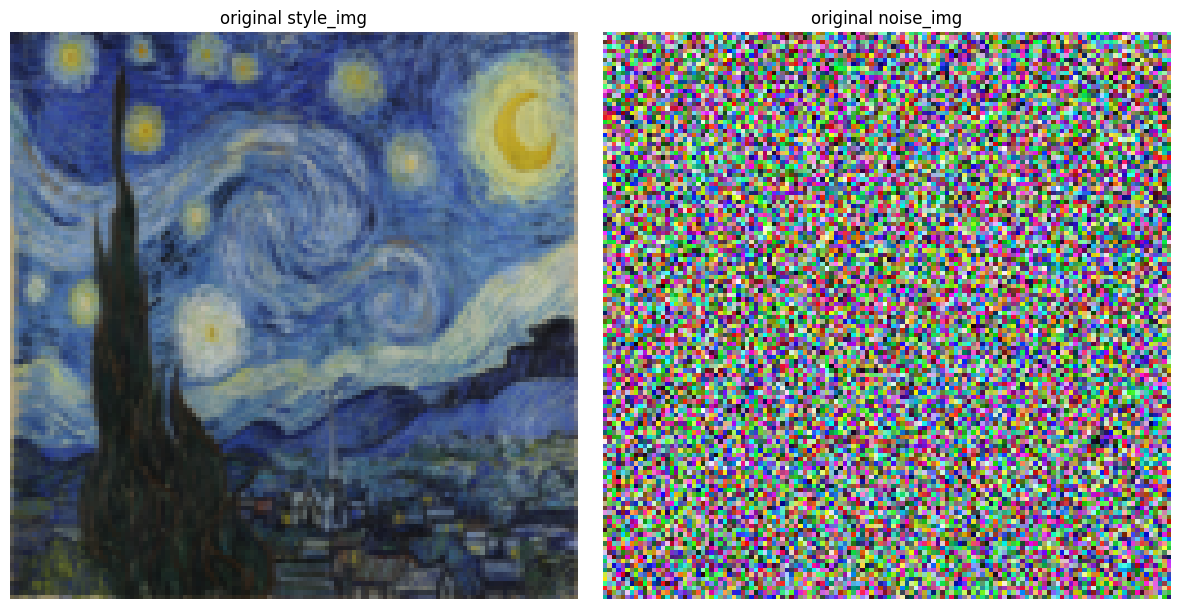

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(style_tensor.squeeze(0)))
plt.title("original style_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("original noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

model = nn.Sequential()
i = 0
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2)
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'
    
    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU(inplace=True)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU(inplace=True)
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU(inplace=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU(inplace=True)
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
style_tensor_output = style_tensor.clone().to(device)
noise_tensor_output = noise_tensor.clone().to(device)

style_tensor_results = {}
noise_tensor_results = {}
for name, layer in model.named_children():
    with torch.no_grad():
        style_tensor_output.clamp_(0, 1)
        noise_tensor_output.clamp_(0, 1)

    style_tensor_output = layer(style_tensor_output)
    noise_tensor_output = layer(noise_tensor_output)

    style_tensor_results[name] = style_tensor_output
    noise_tensor_results[name] = noise_tensor_output

with torch.no_grad():
    style_tensor_output.clamp_(0, 1)
    noise_tensor_output.clamp_(0, 1)

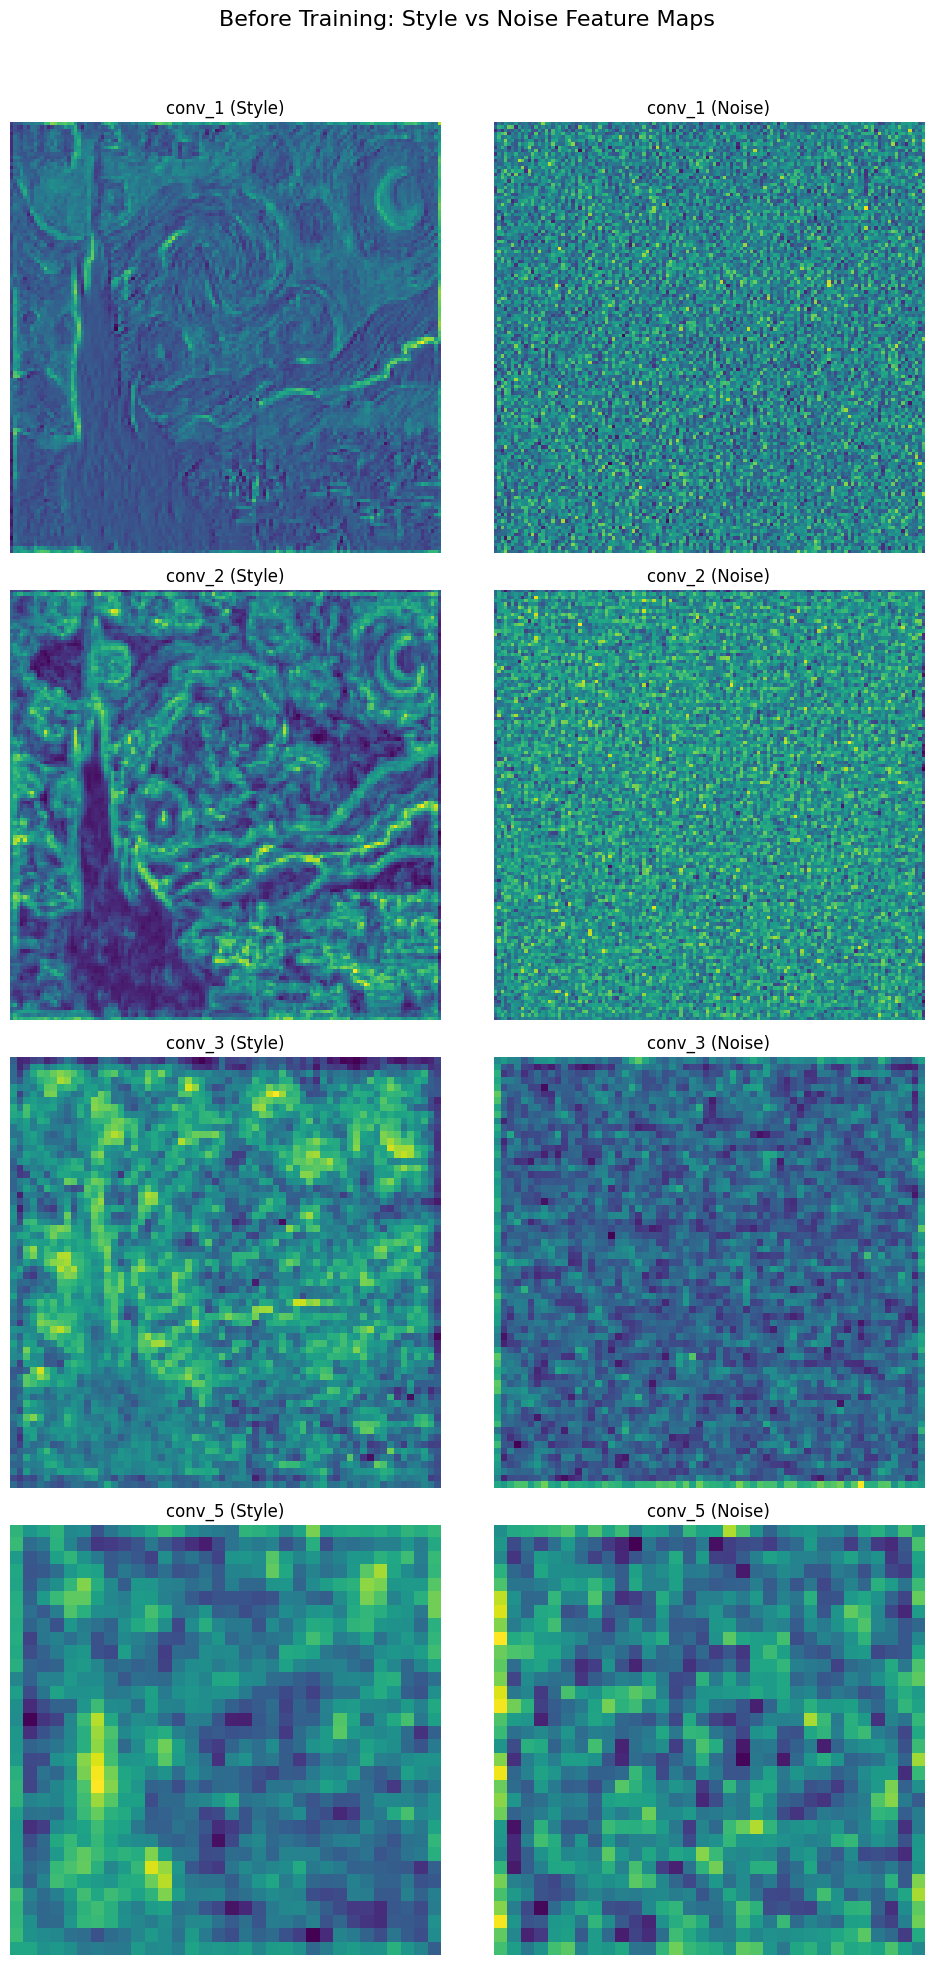

In [10]:
def visualize_feature_maps(style_results, noise_results, layers):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle("Before Training: Style vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        style_feature_map = style_results[layer].squeeze(0).cpu()
        style_mean_map = torch.mean(style_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(style_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Style)")
        axes[i][0].axis("off")

        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

layers_to_visualize = ["conv_1", "conv_2", "conv_3", "conv_5"]
visualize_feature_maps(style_tensor_results, noise_tensor_results, layers_to_visualize)

In [ ]:
style_tensor_output = style_tensor.clone().to(device)

style_tensor_results = {}
for name, layer in model.named_children():
    with torch.no_grad():
        style_tensor_output.clamp_(0, 1)

    style_tensor_output = layer(style_tensor_output)
    style_tensor_results[name] = style_tensor_output

required_grad_noise_tensor = noise_tensor.clone().to(device)
required_grad_noise_tensor.requires_grad_(True)

criterion = nn.MSELoss()
optimizer = optim.SGD([required_grad_noise_tensor], lr=1)

epochs = 10000
for epoch in range(epochs):
    output_tensor = required_grad_noise_tensor
    with torch.no_grad():
        output_tensor.clamp_(0, 1)

    optimizer.zero_grad()

    losses = torch.tensor(0.0, device=device, requires_grad=False)
    for name, layer in model.named_children():
        output_tensor = layer(output_tensor)

        if name == "conv_1":
            losses = losses + criterion(style_tensor_results['conv_1'], output_tensor)

        elif name == "conv_2":
            losses = losses + criterion(style_tensor_results['conv_2'], output_tensor)

        elif name == "conv_3":
            losses = losses + criterion(style_tensor_results['conv_3'], output_tensor)

        elif name == "conv_5":
            losses = losses + criterion(style_tensor_results['conv_5'], output_tensor)
    
    losses.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print(f"{epoch}/{epochs} loss: {losses.item():.4f}")

    if losses.item() == 0.0:
        print(f"Train finished")
        break

with torch.no_grad():
    output_tensor.clamp_(0, 1) # replace

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 128, 64, 64]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).